# Transformer Models

This notebook is used to fine-tune and compare different transformer models. The fine-tuning process involves training the model on a labeled dataset for detecting fake news. We compare the following models:


1. BETO
2. BERT multilingual
3. BERTin
4. RoBERTa
5. SELECTRA
6. ELECTRicidad


Using [Hugging Face](https://huggingface.co/models) library

# Libraries

In [1]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /private/var/folders/2_/ns_bc_y932z_kvppwcct7_080000gn/T/pip-req-build-ryek_4f1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /private/var/folders/2_/ns_bc_y932z_kvppwcct7_080000gn/T/pip-req-build-ryek_4f1
  Resolved https://github.com/huggingface/transformers to commit 699e90437f984d69ad3c9b891dd2e9d0fc2cffe4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.26.0.dev0-py3-none-any.whl size=5858193 sha256=b28ad535b2d93b06473576d499910d6b3e2774d37173a716c8ff678a7b5bb23c
  Stored in directory: /private/var/folders/2_/ns_bc_y932z_kvppwcct7_080000gn/T/pip-ephem-wheel-cache-d59asnfc/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing install

In [27]:
from transformers import AutoTokenizer, DataCollatorWithPadding
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import sklearn                    # machine learning library
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import joblib

# Dataset

In [3]:
df = pd.read_csv('df_lem_spacy_ready.csv')
df.head()

,organizacion,link_desinformacion,texto_desinformacion,topic_desinformacion_raw,topic_desinformacion,label_desinformacion_raw,label_desinformacion,source_desinformacion_raw,source_desinformacion,formato_desinformacion,...,texto_clean,text_lang,lang,long,mentions,hashtags,texto_lem,texto_topic,texto_cut,texto_lem_spacy
0,verificado,https://www.facebook.com/DisculpeLasMolestiasE...,"El Senador del ""PAN"" Javier Lozano, lo dejo bi...",politica,politica nacional,falso,fake,facebook,redes_sociales,texto,...,senador pan javier lozano dejo bien claro si b...,"el senador del ""pan"" javier lozano, lo dejo bi...",es,17,[],[],senador pan javier lozano dejar bien claro si ...,"['senador', 'pan', 'javier', 'lozano', 'dejar'...","['senador', 'pan', 'javier', 'dejar', 'bajar',...",senador pan javier lozano dejar bien claro si ...
1,verificado,https://www.facebook.com/novoideass/photos/p.1...,El actor Gael García Bernal ha mostrado su sim...,politica,politica nacional,falso,fake,facebook,redes_sociales,texto,...,actor gael garcia bernal mostrado simpatia aml...,el actor gael garcía bernal ha mostrado su sim...,es,29,[],[],actor gael garcia bernal mostrar simpatia amlo...,"['actor', 'gael', 'garcia', 'bernal', 'mostrar...","['actor', 'garcia', 'bernal', 'mostrar', 'amlo...",actor gael garcia bernal mostrado simpatia aml...
2,verificado,https://www.facebook.com/watch/?v=519968068404562,AMLO desaparecerá al Ejercito Mexicano.\nEl ta...,politica,politica nacional,falso,fake,facebook,redes_sociales,"texto, video",...,amlo desaparecera ejercito mexicano tabasqueno...,amlo desaparecerá al ejercito mexicano. el tab...,es,19,[],[],amlo desaparecer ejercito mexicano tabasqueno ...,"['amlo', 'desaparecer', 'ejercito', 'perpetuar...","['amlo', 'desaparecer', 'ejercito', 'ejercito'...",amlo desaparecera ejercito mexicano tabasqueno...
3,verificado,https://www.facebook.com/watch/?v=571767869867769,"AMLO\nEl mandamás de Femsa (Coca Cola, Oxxos) ...",politica,politica nacional,falso,fake,facebook,redes_sociales,texto,...,amlo mandamas femsa coca cola oxxos lanza amlo...,"amlo el mandamás de femsa (coca cola, oxxos) s...",es,18,[],['#Recomendado'],amlo mandamas femsa coca cola oxxos lanza amlo...,"['amlo', 'mandamas', 'coca', 'lanza', 'amlo', ...","['amlo', 'coca', 'amlo', 'amlo', 'reforma', 'a...",amlo mandamas femsa coca colo oxxos lanza amlo...
4,verificado,https://www.facebook.com/vamosporella/photos/r...,"LUIS DONALDO COLOSIO RIOJAS, UN PREPARADO Y HO...",politica,politica nacional,falso,fake,facebook,redes_sociales,texto,...,luis donaldo colosio riojas preparado honorabl...,"luis donaldo colosio riojas, un preparado hono...",es,17,[],[],luis donaldo colosio riojas preparado honorabl...,"['luis', 'donaldo', 'colosio', 'riojas', 'fami...","['luis', 'colosio', 'familia', 'sistema', 'pro...",luis donaldo colosio riojas preparado honorabl...


In [4]:
df.label_desinformacion.value_counts()

true    7141
fake    1479
Name: label_desinformacion, dtype: int64

Auxiliar functions from previous work

In [8]:
def print_outputs_tt(X, X_train, X_test, y, y_train, y_test, clf,
                 title='Confusion Matrices'):
    
    X = X.iloc[:,1:]

    y_train_predicted = clf.predict(X_train).predictions.argmax(1)
    y_test_predicted = clf.predict(X_test).predictions.argmax(1)
    
    f1_train = f1_score(y_train, y_train_predicted, average='weighted')
    f1_test = f1_score(y_test, y_test_predicted, average='weighted')

    print('   - F1 weighted score on training set = {:.2f}'.format(f1_train))
    print('   - F1 weighted score on testing set = {:.2f} \n'.format(f1_test))


    confusion = []
    confusion.append(pd.DataFrame(confusion_matrix(y_train, y_train_predicted))) # train
    confusion.append(pd.DataFrame(confusion_matrix(y_test, y_test_predicted))) # test

    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(title, fontsize=12)
    axs = [ax1, ax3]

    for i in range(2):
        sns.heatmap(confusion[i], annot=True, fmt=',.0f', cbar=False, cmap='YlGnBu', ax= axs[i])
        axs[i].set(xticklabels=[0,1], yticklabels=[0,1], xlabel='Predicted label', ylabel='True label')      

    ax1.set_title(f'Training f1 weighted score = {f1_train:.2f}')
    ax3.set_title(f'Testing f1 weighted score = {f1_test:.2f}')

    fig.tight_layout()
    fig.subplots_adjust(top=0.80)

In [9]:
def weighted_f1(y, y_predicted):

  weight_f1_score = f1_score(y, y_predicted, average='weighted')

  fig, ax = plt.subplots()

  ax.set_title(f'\n F1 weighted score on set= {weight_f1_score:.2f}')

  conf = confusion_matrix(y, y_predicted)
  sns.heatmap(conf, annot=True, fmt=',.0f', cbar=False, cmap='YlGnBu', ax= ax)
  ax.set(xticklabels=[0,1,2], yticklabels=[0,1,2], xlabel='Predicted label', ylabel='True label')

X train

In [10]:
X = df0[['texto_lem']]
y = df0.label

In [11]:
train_df, test_df = train_test_split(df0[['texto_lem','label']], test_size=0.10,random_state = 92374)
train_df.shape, test_df.shape

((7758, 2), (862, 2))

In [12]:
#validation
train_df, val_df = train_test_split(train_df, test_size=0.15,random_state = 92374)
train_df.shape, val_df.shape

((6594, 2), (1164, 2))

In [13]:
train_true = train_df[train_df.label==0]
print(train_true.shape)

train_misFake = train_df[train_df.label==1]
print(train_misFake.shape)
train_misFake.head()

(5458, 2)
(1136, 2)


,texto_lem,label
437,aqui transporte invitado ayer hoy austero,1
910,legislador republico argentino multiplicar pes...,1
240,no alcanzar salario vivir acaso no decir salar...,1
486,razon presidente decir hoy abril poder volver ...,1
830,evo no pagar impuesto vehiculo mandatario evas...,1


In [14]:
train_df = pd.concat([
                      train_misFake,
                      train_true.sample(2_000,random_state=123)
])

train_df.label.value_counts()

0    2000
1    1136
Name: label, dtype: int64

In [15]:
X_train1 = train_df.texto_lem
y_train1 = train_df.label

X_val1 = val_df.texto_lem
y_val1 = val_df.label

X_test1 = test_df.texto_lem
y_test1 = test_df.label

In [16]:
print('Number of rows: y_train:{}, y_val:{}, y_test:{}, Total:{}'.format(len(y_train1), len(y_val1), len(y_test1), len(y)))

print('\nDistribution by classes:')
pd.DataFrame({'train set':np.unique(y_train1, return_counts=True)[1], 
              'validation set': np.unique(y_val1, return_counts=True)[1], 
              'test set': np.unique(y_test1, return_counts=True)[1]})

Number of rows: y_train:3136, y_val:1164, y_test:862, Total:8620

Distribution by classes:


,train set,validation set,test set
0,2000,984,699
1,1136,180,163


In [17]:
X_train = list(X_train1)
y_train = list(y_train1)

X_val = list(X_val1)
y_val = list(y_val1)

X_test = list(X_test1)
y_test = list(y_test1)

print('train:', len(X_train), len(y_train))
print('validation:', len(X_val), len(y_val))
print('test:',len(X_test), len(y_test))

train: 3136 3136
validation: 1164 1164
test: 862 862


# BETO

In [18]:
checkpoint = 'dccuchile/bert-base-spanish-wwm-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [19]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [20]:
import torch

class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, y_train)
val_dataset = FakeNewsDataset(val_encodings, y_val)
test_dataset = FakeNewsDataset(test_encodings, y_test)

In [21]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [22]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer",evaluation_strategy="epoch")

In [23]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds,average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [24]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [25]:
trainer.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3136
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1176
  Number of trainable parameters = 109852418


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.214361,0.952749,0.953513,0.954796,0.952749
2,0.294100,0.228279,0.951890,0.953368,0.956816,0.951890
3,0.157900,0.204854,0.958763,0.959636,0.961434,0.958763


***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1176, training_loss=0.20974239362340394, metrics={'train_runtime': 168039.7392, 'train_samples_per_second': 0.056, 'train_steps_per_second': 0.007, 'total_flos': 2475348808826880.0, 'train_loss': 0.20974239362340394, 'epoch': 3.0})

In [26]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


{'eval_loss': 0.20485354959964752,
 'eval_accuracy': 0.9587628865979382,
 'eval_f1': 0.9596363842988789,
 'eval_precision': 0.9614343157804681,
 'eval_recall': 0.9587628865979382,
 'eval_runtime': 4800.9106,
 'eval_samples_per_second': 0.242,
 'eval_steps_per_second': 0.03,
 'epoch': 3.0}

***** Running Prediction *****
  Num examples = 3136
  Batch size = 8
***** Running Prediction *****
  Num examples = 862
  Batch size = 8


   - F1 weighted score on training set = 0.98
   - F1 weighted score on testing set = 0.96 



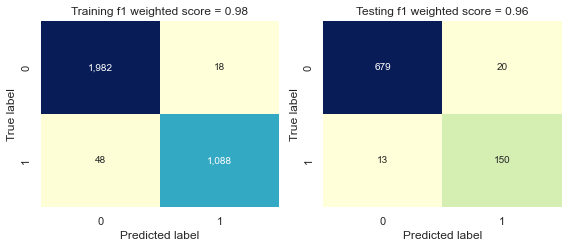

In [28]:
print_outputs_tt(X, train_dataset, test_dataset, y, y_train, y_test, trainer,'')

In [29]:
#saving
path = 'Beto_model'
trainer.save_model(path)

Saving model checkpoint to Beto_model
Configuration saved in Beto_model/config.json
Model weights saved in Beto_model/pytorch_model.bin


# RoBERTa 

In [31]:
checkpoint2 = 'xlm-roberta-base'
tokenizer2 = AutoTokenizer.from_pretrained(checkpoint2)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/42f548f32366559214515ec137cdd16002968bf6/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading file

In [32]:
train_encodings = tokenizer2(X_train, truncation=True, padding=True)
val_encodings = tokenizer2(X_val, truncation=True, padding=True)
test_encodings = tokenizer2(X_test, truncation=True, padding=True)

In [33]:
model2 = AutoModelForSequenceClassification.from_pretrained(checkpoint2, num_labels=2)

loading configuration file config.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/42f548f32366559214515ec137cdd16002968bf6/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

Downloading: 100%|█████████████████████████| 1.12G/1.12G [02:15<00:00, 8.26MB/s]
loading weights file pyt

In [34]:
training_args = TrainingArguments("test_trainer2",evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [35]:
trainer2 = Trainer(
    model=model2, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [36]:
trainer2.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3136
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1176
  Number of trainable parameters = 278045186


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.273059,0.922680,0.925056,0.929234,0.922680
2,0.479500,0.261808,0.939863,0.940522,0.941407,0.939863
3,0.319700,0.292061,0.914089,0.917928,0.925717,0.914089


***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer2/checkpoint-500
Configuration saved in test_trainer2/checkpoint-500/config.json
Model weights saved in test_trainer2/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer2/checkpoint-1000
Configuration saved in test_trainer2/checkpoint-1000/config.json
Model weights saved in test_trainer2/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1176, training_loss=0.38041765511441394, metrics={'train_runtime': 91542.0147, 'train_samples_per_second': 0.103, 'train_steps_per_second': 0.013, 'total_flos': 2475348808826880.0, 'train_loss': 0.38041765511441394, 'epoch': 3.0})

In [38]:
trainer2.evaluate()

***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


{'eval_loss': 0.29206129908561707,
 'eval_accuracy': 0.9140893470790378,
 'eval_f1': 0.9179281396007443,
 'eval_precision': 0.9257167639716622,
 'eval_recall': 0.9140893470790378,
 'eval_runtime': 270.755,
 'eval_samples_per_second': 4.299,
 'eval_steps_per_second': 0.539,
 'epoch': 3.0}

***** Running Prediction *****
  Num examples = 3136
  Batch size = 8
***** Running Prediction *****
  Num examples = 862
  Batch size = 8


   - F1 weighted score on training set = 0.91
   - F1 weighted score on testing set = 0.91 



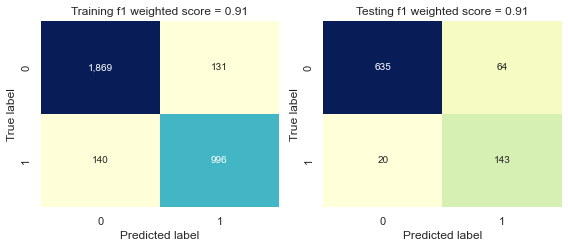

In [39]:
print_outputs_tt(X, train_dataset, test_dataset, y, y_train, y_test, trainer2,'')

In [37]:
#saving
path = 'Roberta_model'
trainer2.save_model(path)

Saving model checkpoint to Roberta_model
Configuration saved in Roberta_model/config.json
Model weights saved in Roberta_model/pytorch_model.bin


# BERT multilingual

In [40]:
checkpoint3 = 'bert-base-multilingual-uncased'
tokenizer3 = AutoTokenizer.from_pretrained(checkpoint3)

Downloading: 100%|███████████████████████████| 28.0/28.0 [00:00<00:00, 12.9kB/s]
Downloading: 100%|██████████████████████████████| 625/625 [00:00<00:00, 167kB/s]
loading configuration file config.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/800c34f3d5aa174fe531f560b44b8d14592225b7/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "

In [41]:
train_encodings = tokenizer3(X_train, truncation=True, padding=True)
val_encodings = tokenizer3(X_val, truncation=True, padding=True)
test_encodings = tokenizer3(X_test, truncation=True, padding=True)

In [42]:
model3 = AutoModelForSequenceClassification.from_pretrained(checkpoint3, num_labels=2)

loading configuration file config.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--bert-base-multilingual-uncased/snapshots/800c34f3d5aa174fe531f560b44b8d14592225b7/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0.dev0",
  "type_vocab_size": 2,
  "use_cache": tr

In [43]:
training_args = TrainingArguments("test_trainer3",evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [44]:
trainer3 = Trainer(
    model=model3, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [45]:
trainer3.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3136
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1176
  Number of trainable parameters = 167357954


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.337692,0.893471,0.899875,0.913576,0.893471
2,0.356300,0.333273,0.921821,0.924986,0.931407,0.921821
3,0.295700,0.280825,0.935567,0.937367,0.940700,0.935567


***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer3/checkpoint-500
Configuration saved in test_trainer3/checkpoint-500/config.json
Model weights saved in test_trainer3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer3/checkpoint-1000
Configuration saved in test_trainer3/checkpoint-1000/config.json
Model weights saved in test_trainer3/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1176, training_loss=0.31151794900699536, metrics={'train_runtime': 81263.0613, 'train_samples_per_second': 0.116, 'train_steps_per_second': 0.014, 'total_flos': 2475348808826880.0, 'train_loss': 0.31151794900699536, 'epoch': 3.0})

In [46]:
trainer3.evaluate()

***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


{'eval_loss': 0.2808251976966858,
 'eval_accuracy': 0.9355670103092784,
 'eval_f1': 0.9373665298445104,
 'eval_precision': 0.9407002215855521,
 'eval_recall': 0.9355670103092784,
 'eval_runtime': 3500.4856,
 'eval_samples_per_second': 0.333,
 'eval_steps_per_second': 0.042,
 'epoch': 3.0}

***** Running Prediction *****
  Num examples = 3136
  Batch size = 8
***** Running Prediction *****
  Num examples = 862
  Batch size = 8


   - F1 weighted score on training set = 0.95
   - F1 weighted score on testing set = 0.94 



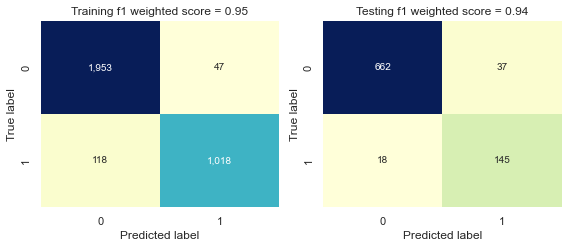

In [47]:
print_outputs_tt(X, train_dataset, test_dataset, y, y_train, y_test, trainer3,'')

In [48]:
#saving
path = 'Bertmulti_model'
trainer3.save_model(path)

Saving model checkpoint to Bertmulti_model
Configuration saved in Bertmulti_model/config.json
Model weights saved in Bertmulti_model/pytorch_model.bin


# BERTin

In [50]:
checkpoint4 = 'bertin-project/bertin-roberta-base-spanish'
tokenizer4 = AutoTokenizer.from_pretrained(checkpoint4)

Downloading: 100%|██████████████████████████| 1.12k/1.12k [00:00<00:00, 299kB/s]
Downloading: 100%|███████████████████████████| 851k/851k [00:00<00:00, 2.29MB/s]
Downloading: 100%|███████████████████████████| 509k/509k [00:00<00:00, 1.20MB/s]
Downloading: 100%|█████████████████████████| 2.21M/2.21M [00:00<00:00, 3.40MB/s]
Downloading: 100%|██████████████████████████████| 772/772 [00:00<00:00, 220kB/s]
loading file vocab.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--bertin-project--bertin-roberta-base-spanish/snapshots/cb1844d753a963f4f4f716ab8db723628669964b/vocab.json
loading file merges.txt from cache at /Users/pautrejo/.cache/huggingface/hub/models--bertin-project--bertin-roberta-base-spanish/snapshots/cb1844d753a963f4f4f716ab8db723628669964b/merges.txt
loading file tokenizer.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--bertin-project--bertin-roberta-base-spanish/snapshots/cb1844d753a963f4f4f716ab8db723628669964b/tokenizer.json
loading file a

In [51]:
train_encodings = tokenizer4(X_train, truncation=True, padding=True)
val_encodings = tokenizer4(X_val, truncation=True, padding=True)
test_encodings = tokenizer4(X_test, truncation=True, padding=True)

In [52]:
model4 = AutoModelForSequenceClassification.from_pretrained(checkpoint4, num_labels=2)

Downloading: 100%|██████████████████████████████| 674/674 [00:00<00:00, 180kB/s]
loading configuration file config.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--bertin-project--bertin-roberta-base-spanish/snapshots/cb1844d753a963f4f4f716ab8db723628669964b/config.json
Model config RobertaConfig {
  "_name_or_path": "bertin-project/bertin-roberta-base-spanish",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0.dev0",
  "type_vocab_size": 1,
  "use_cache": t

In [53]:
training_args = TrainingArguments("test_trainer4",evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [54]:
trainer4 = Trainer(
    model=model4, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [55]:
trainer4.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3136
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1176
  Number of trainable parameters = 124644866


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.586919,0.823024,0.843159,0.899271,0.823024
2,0.379100,0.224034,0.945017,0.946073,0.947851,0.945017
3,0.215300,0.239508,0.942440,0.944047,0.947222,0.942440


***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer4/checkpoint-500
Configuration saved in test_trainer4/checkpoint-500/config.json
Model weights saved in test_trainer4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer4/checkpoint-1000
Configuration saved in test_trainer4/checkpoint-1000/config.json
Model weights saved in test_trainer4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1176, training_loss=0.2772191673719964, metrics={'train_runtime': 60127.8623, 'train_samples_per_second': 0.156, 'train_steps_per_second': 0.02, 'total_flos': 2475348808826880.0, 'train_loss': 0.2772191673719964, 'epoch': 3.0})

In [56]:
trainer4.evaluate()

***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


{'eval_loss': 0.23950840532779694,
 'eval_accuracy': 0.9424398625429553,
 'eval_f1': 0.9440474333277625,
 'eval_precision': 0.947221796786705,
 'eval_recall': 0.9424398625429553,
 'eval_runtime': 285.0964,
 'eval_samples_per_second': 4.083,
 'eval_steps_per_second': 0.512,
 'epoch': 3.0}

***** Running Prediction *****
  Num examples = 3136
  Batch size = 8
***** Running Prediction *****
  Num examples = 862
  Batch size = 8


   - F1 weighted score on training set = 0.97
   - F1 weighted score on testing set = 0.94 



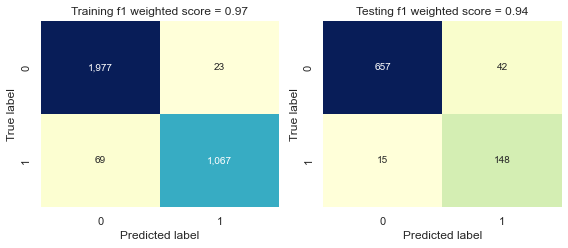

In [57]:
print_outputs_tt(X, train_dataset, test_dataset, y, y_train, y_test, trainer4,'')

In [58]:
#saving
path = 'Bertin_model'
trainer4.save_model(path)

Saving model checkpoint to Bertin_model
Configuration saved in Bertin_model/config.json
Model weights saved in Bertin_model/pytorch_model.bin


# SELECTRA

In [59]:
checkpoint5 = 'Recognai/selectra_small'
tokenizer5 = AutoTokenizer.from_pretrained(checkpoint5)

Downloading: 100%|███████████████████████████| 72.0/72.0 [00:00<00:00, 20.6kB/s]
Downloading: 100%|██████████████████████████████| 466/466 [00:00<00:00, 158kB/s]
loading configuration file config.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--Recognai--selectra_small/snapshots/e45e0de5d6a68200c4b6894d06e16d7b3ef3ace4/config.json
Model config ElectraConfig {
  "_name_or_path": "Recognai/selectra_small",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 256,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first"

In [60]:
train_encodings = tokenizer5(X_train, truncation=True, padding=True)
val_encodings = tokenizer5(X_val, truncation=True, padding=True)
test_encodings = tokenizer5(X_test, truncation=True, padding=True)

In [61]:
model5 = AutoModelForSequenceClassification.from_pretrained(checkpoint5, num_labels=2)

loading configuration file config.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--Recognai--selectra_small/snapshots/e45e0de5d6a68200c4b6894d06e16d7b3ef3ace4/config.json
Model config ElectraConfig {
  "_name_or_path": "Recognai/selectra_small",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 256,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.26.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

Downloading: 100%|███

In [62]:
training_args = TrainingArguments("test_trainer5",evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [63]:
trainer5 = Trainer(
    model=model5, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [64]:
trainer5.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3136
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1176
  Number of trainable parameters = 22475522


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.270568,0.920962,0.923678,0.928670,0.920962
2,0.328100,0.236330,0.939003,0.939209,0.939435,0.939003
3,0.243200,0.265342,0.931271,0.933255,0.936862,0.931271


***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer5/checkpoint-500
Configuration saved in test_trainer5/checkpoint-500/config.json
Model weights saved in test_trainer5/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer5/checkpoint-1000
Configuration saved in test_trainer5/checkpoint-1000/config.json
Model weights saved in test_trainer5/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1176, training_loss=0.2738379523867652, metrics={'train_runtime': 42077.8252, 'train_samples_per_second': 0.224, 'train_steps_per_second': 0.028, 'total_flos': 275832940658688.0, 'train_loss': 0.2738379523867652, 'epoch': 3.0})

In [65]:
trainer5.evaluate()

***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


{'eval_loss': 0.265341579914093,
 'eval_accuracy': 0.9312714776632303,
 'eval_f1': 0.9332553937719203,
 'eval_precision': 0.9368623062655327,
 'eval_recall': 0.9312714776632303,
 'eval_runtime': 2031.2407,
 'eval_samples_per_second': 0.573,
 'eval_steps_per_second': 0.072,
 'epoch': 3.0}

***** Running Prediction *****
  Num examples = 3136
  Batch size = 8
***** Running Prediction *****
  Num examples = 862
  Batch size = 8


   - F1 weighted score on training set = 0.95
   - F1 weighted score on testing set = 0.92 



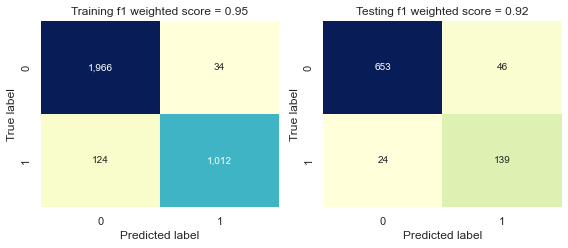

In [66]:
print_outputs_tt(X, train_dataset, test_dataset, y, y_train, y_test, trainer5,'')

In [67]:
#saving
path = 'selectra_model'
trainer5.save_model(path)

Saving model checkpoint to selectra_model
Configuration saved in selectra_model/config.json
Model weights saved in selectra_model/pytorch_model.bin


# ELECTRicidad

In [68]:
checkpoint6 = 'mrm8488/electricidad-base-discriminator'
tokenizer6 = AutoTokenizer.from_pretrained(checkpoint6)

Could not locate the tokenizer configuration file, will try to use the model config instead.
Downloading: 100%|██████████████████████████████| 467/467 [00:00<00:00, 103kB/s]
loading configuration file config.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--mrm8488--electricidad-base-discriminator/snapshots/1353d86e74c5ae322590dcda6e216259b1f72b67/config.json
Model config ElectraConfig {
  "_name_or_path": "mrm8488/electricidad-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_

In [69]:
train_encodings = tokenizer6(X_train, truncation=True, padding=True)
val_encodings = tokenizer6(X_val, truncation=True, padding=True)
test_encodings = tokenizer6(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [70]:
model6 = AutoModelForSequenceClassification.from_pretrained(checkpoint6, num_labels=2)

loading configuration file config.json from cache at /Users/pautrejo/.cache/huggingface/hub/models--mrm8488--electricidad-base-discriminator/snapshots/1353d86e74c5ae322590dcda6e216259b1f72b67/config.json
Model config ElectraConfig {
  "_name_or_path": "mrm8488/electricidad-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.26.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size

In [71]:
training_args = TrainingArguments("test_trainer6",evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [72]:
trainer6 = Trainer(
    model=model6, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [73]:
trainer6.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3136
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1176
  Number of trainable parameters = 109852418


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.196395,0.950172,0.949942,0.949752,0.950172
2,0.310200,0.283427,0.932131,0.934278,0.938402,0.932131
3,0.186300,0.337996,0.924399,0.927901,0.935816,0.924399


***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer6/checkpoint-500
Configuration saved in test_trainer6/checkpoint-500/config.json
Model weights saved in test_trainer6/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8
Saving model checkpoint to test_trainer6/checkpoint-1000
Configuration saved in test_trainer6/checkpoint-1000/config.json
Model weights saved in test_trainer6/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1176, training_loss=0.23029601168470318, metrics={'train_runtime': 67253.094, 'train_samples_per_second': 0.14, 'train_steps_per_second': 0.017, 'total_flos': 2475348808826880.0, 'train_loss': 0.23029601168470318, 'epoch': 3.0})

In [74]:
trainer6.evaluate()

***** Running Evaluation *****
  Num examples = 1164
  Batch size = 8


{'eval_loss': 0.33799612522125244,
 'eval_accuracy': 0.9243986254295533,
 'eval_f1': 0.9279007479280371,
 'eval_precision': 0.9358162787354322,
 'eval_recall': 0.9243986254295533,
 'eval_runtime': 2059.4859,
 'eval_samples_per_second': 0.565,
 'eval_steps_per_second': 0.071,
 'epoch': 3.0}

***** Running Prediction *****
  Num examples = 3136
  Batch size = 8
***** Running Prediction *****
  Num examples = 862
  Batch size = 8


   - F1 weighted score on training set = 0.98
   - F1 weighted score on testing set = 0.94 



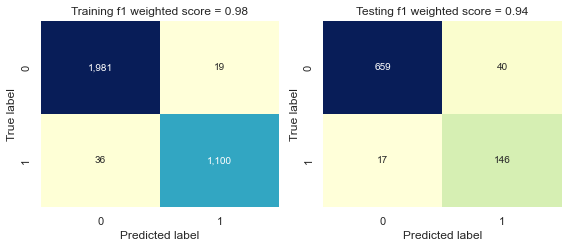

In [75]:
print_outputs_tt(X, train_dataset, test_dataset, y, y_train, y_test, trainer6,'')

In [76]:
#saving
path = 'electricidad_model'
trainer6.save_model(path)

Saving model checkpoint to electricidad_model
Configuration saved in electricidad_model/config.json
Model weights saved in electricidad_model/pytorch_model.bin
